# Firts attempts & Base Model

In [77]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
path_project = Path.home() / Path('Google Drive/Felix')
path_data = path_project / Path("data")

In [3]:
# loading cdv data
file = path_data / Path("felix.csv")
with Path.open(file, 'rb') as fp:
    cdv = pd.read_csv(fp,  encoding='cp1252',low_memory=False)

## 1) Feature engineering & variable selection

In [4]:
df = cdv.loc[:,["NOT_FAMI", "NOT_PROF", "NOT_AMIS",
                "NOT_COHE", "NOT_POLI", "NOT_LIBR", 
                "NOT_LOG", "NOT_CAD",
                "CONFPUB","CONFENTR","CONFASSO","CONFPOLI","CONFBANK",
                "CONFPRES","CONFECOL","CONFKEUF","HEUREUX"]]

### Selection of variable with low frequency of missing values

In [5]:
missing_values = np.sum(df.isnull()).sort_values(ascending = False)
missing_values

NOT_CAD     5206
NOT_LOG     5199
CONFECOL    2045
CONFPRES    2045
CONFBANK    2045
CONFKEUF    2045
NOT_PROF     185
NOT_POLI     184
NOT_COHE     177
NOT_LIBR     171
NOT_AMIS     157
NOT_FAMI     133
HEUREUX        0
CONFENTR       0
CONFASSO       0
CONFPOLI       0
CONFPUB        0
dtype: int64

In [6]:
selected_variable = missing_values[missing_values < 2000].index

In [7]:
selected_variable

Index(['NOT_PROF', 'NOT_POLI', 'NOT_COHE', 'NOT_LIBR', 'NOT_AMIS', 'NOT_FAMI',
       'HEUREUX', 'CONFENTR', 'CONFASSO', 'CONFPOLI', 'CONFPUB'],
      dtype='object')

In [8]:
df = cdv.loc[:,selected_variable]

Dropping remaining missing values

In [9]:
print(f"Number of exemple before dropping missing value {df.shape[0]}")
df.dropna(inplace=True)
print(f"Number of exemple after dropping missing value {df.shape[0]}")

Number of exemple before dropping missing value 11131
Number of exemple after dropping missing value 10701


### Variable encoding - HEUREUX

In [10]:
df["HEUREUX"].value_counts()

Assez souvent        5240
Occasionnellement    3537
Très souvent         1702
Jamais                195
[Nsp]                  27
Name: HEUREUX, dtype: int64

In [11]:
# reducing problem to a 2 class classification problem
df["HEUREUX_CLF"] = 0
df.loc[df["HEUREUX"]=="Très souvent", "HEUREUX_CLF"] = 1
df.loc[df["HEUREUX"]=="Assez souvent", "HEUREUX_CLF"] = 1

In [12]:
# Modelisation as a 5 multi class classification problem
df["HEUREUX_MCLF"] = 0
df.loc[df["HEUREUX"]=="Très souvent", "HEUREUX_MCLF"] = 4
df.loc[df["HEUREUX"]=="Assez souvent", "HEUREUX_MCLF"] = 3
df.loc[df["HEUREUX"]=="Occasionnellement", "HEUREUX_MCLF"] = 2
df.loc[df["HEUREUX"]=="Jamais", "HEUREUX_MCLF"] = 1
df.loc[df["HEUREUX"]=="[Nsp]", "HEUREUX_MCLF"] = 0

In [13]:
# Modelisation as a regression problem
df["HEUREUX_REG"] = None
df.loc[df["HEUREUX"]=="Très souvent", "HEUREUX_REG"] = 3
df.loc[df["HEUREUX"]=="Assez souvent", "HEUREUX_REG"] = 2
df.loc[df["HEUREUX"]=="Occasionnellement", "HEUREUX_REG"] = 1
df.loc[df["HEUREUX"]=="Jamais", "HEUREUX_REG"] = 0
df.loc[df["HEUREUX"]=="[Nsp]", "HEUREUX_REG"] = None
# NB '[Nsp]' lines should be removed, ...

### Variable encoding - others

In [14]:
# Coding of N3 variables
for c in ["CONFPUB","CONFENTR","CONFASSO","CONFPOLI"]:
    df[c +"_NUM"] = 0
    df.loc[df[c]=='Pas du tout confiance',c +"_NUM"] = -2
    df.loc[df[c]=='Plutôt pas confiance',c +"_NUM"] = -1
    df.loc[df[c]=='[Nsp]',c +"_NUM"] = 0
    df.loc[df[c]=='Plutôt confiance',c +"_NUM"] = 1
    df.loc[df[c]=='Très confiance',c +"_NUM"] = 2

## 2) Base Classification model

### a) Builing training set and test set

In [19]:
features = ["NOT_FAMI", "NOT_PROF", "NOT_AMIS","NOT_COHE", "NOT_POLI", "NOT_LIBR", 
            "CONFPUB_NUM","CONFENTR_NUM","CONFASSO_NUM","CONFPOLI_NUM"]

X = df.loc[:,features]
y = df["HEUREUX_CLF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: \n- training set: {y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")

Number exemple: 
- training set: 8560
- test set: 2141
Number of features: p=10


### b) Visualisation of the data

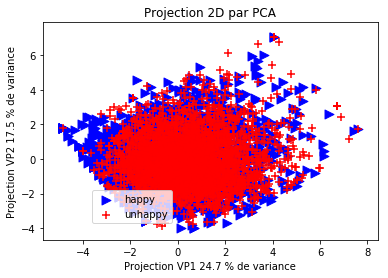

In [20]:
# Reduction dim PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_r = pca.transform(X_train)
happy = (y_train==1)
unhappy = (y_train==0)
plt.scatter(X_r[happy,0], X_r[happy,1], s=80, c='blue',marker=">", label="happy")
plt.scatter(X_r[unhappy,0], X_r[unhappy,1], s=80, c='red',marker='+', label="unhappy")
plt.ylabel(u'Projection VP2 %0.1f %% de variance' % (pca.explained_variance_ratio_[1]*100))
plt.xlabel(u'Projection VP1 %0.1f %% de variance' % (pca.explained_variance_ratio_[0]*100))
plt.title(u"Projection 2D par PCA") 
plt.legend(bbox_to_anchor=(0.4, 0.25))
plt.show()

### c) Logistic Regression - 2 class

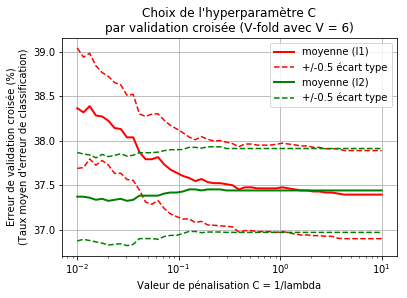

Détermination des paramètres optimaux en 20.1 s
Pénalisation l1, valeur optimale : C = 4.29
Pénalisation l2, valeur optimale : C = 0.02


In [49]:
nb_value = 50 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2,1,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                               scoring='accuracy'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                             scoring='accuracy'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                               scoring='accuracy'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                             scoring='accuracy'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:], 'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel(u"Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.2f" % (C_log[np.argmin(mean_score_l2)]))

[ 0.23018086  0.20834431  0.20338     0.14246087  0.07911247  0.05286514
  0.04325246  0.0271686   0.02600208  0.01665714]
[2 0 7 6 9 4 5 3 1 8]


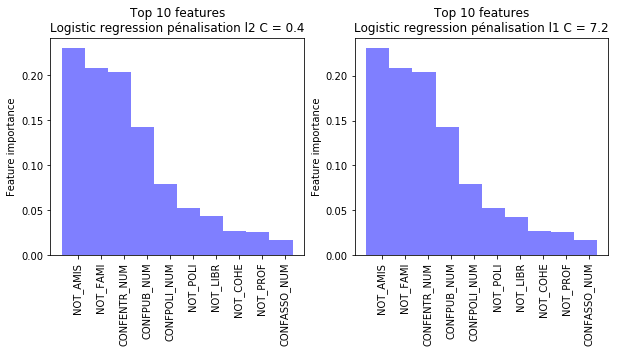

In [42]:
# Use regression coefficients to rank features
clf = LogisticRegression(penalty='l2',C=0.4)
    
clf.fit(X_train,y_train)
coef_l2 = abs(clf.coef_)
coef_sorted_l2 = -np.sort(-coef_l2).reshape(-1)
print(coef_sorted_l2)
features_sorded_l2 = np.argsort(-coef_l2).reshape(-1)
print(features_sorded_l2)
features_name = np.array(features)
features_name_sorted_l2 = features_name[features_sorded_l2]
    
clf = LogisticRegression(penalty='l1',C=7.2)
    
clf.fit(X_train,y_train)
coef_l1 = abs(clf.coef_)
coef_sorted_l1 = -np.sort(-coef_l1).reshape(-1)
features_sorded_l1 = np.argsort(-coef_l1).reshape(-1)
features_name_sorted_l1 = features_name[features_sorded_l1]

nf = len(features)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ind = np.arange(nf)    # the x locations for the groups

plt.subplot(1, 2, 1)
p1 = plt.bar(ind, coef_sorted_l2[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l2 C = 0.4' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l2[0:nf], rotation = 90)

plt.subplot(1, 2, 2)
p1 = plt.bar(ind, coef_sorted_l1[0:nf], 1, color='b',alpha=0.5)
plt.ylabel('Feature importance')
plt.title(u'Top %i features\nLogistic regression pénalisation l1 C = 7.2' % nf)
plt.xticks(ind + 0.35/2.0, features_name_sorted_l1[0:nf], rotation = 90)

plt.show()

In [38]:
features
features_name = np.array(features)
features_name[[1,2,6]]

array(['NOT_PROF', 'NOT_AMIS', 'CONFPUB_NUM'],
      dtype='<U12')

In [47]:
startTime = time.time()
n_estimators_range = [16,32,64,128]
max_depth_range = [2,4,8,16,32,64,128,256] 
param_grid = dict(n_estimators=n_estimators_range, max_depth = max_depth_range)


params = {'max_features' :'sqrt', 'random_state' : 32, 'min_samples_split' : 2, 'class_weight' : 'balanced'}
clf = RandomForestClassifier(**params)

grid = GridSearchCV(clf, scoring='accuracy', param_grid=param_grid)
grid.fit(X_train, y_train)
print(f"Determination of optimal hyperparameters in {time.time() - startTime:0.1f} s")
print(f"Optimal values are {grid.best_params_} \nAccuracy Score of cross valdation {100*grid.best_score_:0.2f}%")

# Learning on full training set with optimals hyperparameters and score on test set
params = {'max_features' :'sqrt', 'random_state' : 32, 
          'min_samples_split' : 2, 'class_weight' : 'balanced',
          'n_estimators' : grid.best_params_['n_estimators'],
          'max_depth' : grid.best_params_['max_depth']}
clf = RandomForestClassifier(**params).fit(X_train, y_train)
y = clf.predict(X_test)
accruacy = clf.score(X_test, y_test)
print(accruacy)
#rmse = np.sqrt(mean_squared_error(y_test, y))
#print "RMSE: {:0.4f}".format(rmse)
#r2 = r2_score(y_test, y)
#print "R2: {:0.2f}%".format(r2*100)
print(f"... done in {time.time() - startTime:0.1f}")

Determination of optimal hyperparameters in 46.5 s
Optimal values are {'max_depth': 16, 'n_estimators': 128} 
Accuracy Score of cross valdation 63.68%
0.622606258758
... done in 47.8


In [48]:
clf.score(X_test, y_test, sample_weight=None )

0.6226062587575899

### d) Multi class regression

In [53]:
y = df["HEUREUX_MCLF"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Number exemple: \n- training set: {y_train.shape[0]}\n- test set: {y_test.shape[0]}")
print(f"Number of features: p={X_train.shape[1]}")

Number exemple: 
- training set: 8560
- test set: 2141
Number of features: p=10


//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/s

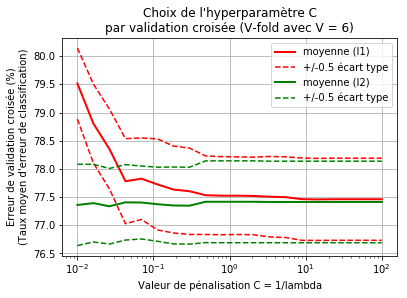

Détermination des paramètres optimaux en 28.8 s
Pénalisation l1, valeur optimale : C = 14.3845
Pénalisation l2, valeur optimale : C = 0.0264


In [112]:
nb_value = 20 # Nombre de valeurs testées pour l'hyperparamètre
mean_score_l1 = np.zeros(nb_value)
mean_score_l2 = np.zeros(nb_value)
C_log = np.logspace(-2,2,nb_value)
cv = 6 # V-fold, nombre de fold

mean_score_l1 = np.empty(nb_value)
std_scores_l1 = np.empty(nb_value)

mean_score_l2 = np.empty(nb_value)
std_scores_l2 = np.empty(nb_value)

np.random.seed(seed=42) 

startTime = time.time()

for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l1[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                               scoring='f1_macro'))
    std_scores_l1[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                             scoring='f1_macro'))    


for i, C in enumerate(C_log):
    clf = LogisticRegression(C=C, penalty='l2', tol=0.01, random_state=42, class_weight='balanced')
    mean_score_l2[i] = 100*np.mean(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                               scoring='f1_macro'))
    std_scores_l2[i] = 100*np.std(1-cross_val_score(clf, X_train, y_train, cv=cv, 
                                                             scoring='f1_macro'))    
    
plt.figure()
plt.semilogx(C_log,mean_score_l1[:],'r',linewidth=2,label='moyenne (l1)')
plt.semilogx(C_log,mean_score_l1[:]-0.5*std_scores_l1[:], 'r--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l1[:]+0.5*std_scores_l1[:],'r--')

plt.semilogx(C_log,mean_score_l2[:],'g',linewidth=2,label='moyenne (l2)')
plt.semilogx(C_log,mean_score_l2[:]-0.5*std_scores_l2[:], 'g--', label=u'+/-0.5 écart type')
plt.semilogx(C_log,mean_score_l2[:]+0.5*std_scores_l2[:],'g--')

plt.xlabel(u"Valeur de pénalisation C = 1/lambda")
plt.ylabel(u"Erreur de validation croisée (%)\n(Taux moyen d'erreur de classification)")
plt.title(u"Choix de l'hyperparamètre C\npar validation croisée \
(V-fold avec V = %s)" % (cv)) 
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.show()
print("Détermination des paramètres optimaux en %0.1f s" % (time.time() - startTime))
print("Pénalisation l1, valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_l1)]))
print("Pénalisation l2, valeur optimale : C = %0.4f" % (C_log[np.argmin(mean_score_l2)]))

In [113]:
# Learning on full training set with optimals hyperparameters and score on test set
clf = LogisticRegression(C=C_log[np.argmin(mean_score_l1)], penalty='l1', tol=0.01, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


# Modelisation as a 5 multi class classification problem

class_names = ["[Nsp]","Jamais","Occasionnellement","Assez souvent","Très souvent" ]


Confusion matrix, without normalization
[[  0   0   2   3   0]
 [  3  10  14  14   0]
 [ 59  51 213 354   4]
 [ 65  44 217 735  13]
 [ 24  17  43 248   8]]
Normalized confusion matrix
[[ 0.    0.    0.4   0.6   0.  ]
 [ 0.07  0.24  0.34  0.34  0.  ]
 [ 0.09  0.07  0.31  0.52  0.01]
 [ 0.06  0.04  0.2   0.68  0.01]
 [ 0.07  0.05  0.13  0.73  0.02]]


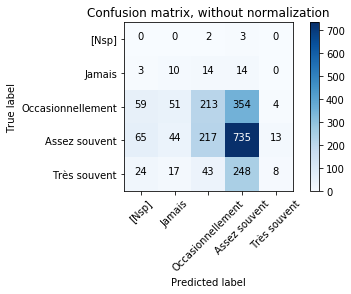

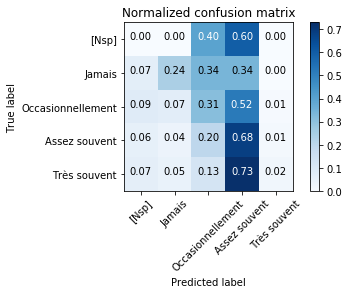

In [114]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [115]:
y_test.value_counts()

3    1074
2     681
4     340
1      41
0       5
Name: HEUREUX_MCLF, dtype: int64